# Toy Example: Environment Spill Function

In [1]:
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from psimpy.sampler.latin import LHS
from psimpy.emulator import PPGaSP, PCAPPGaSP
from psimpy.emulator import OutputDimReducer, LinearPCA, NonlinearPCA
from psimpy.utility import reduced_dim
from gpytorch_emulator import MoGP_GPytorch, PCA_MoGP_GPytorch, MultiTask_GP
from utils.error_metrics import ErrorMetrics
from utils.plot import viz_prediction

In [2]:
# Get the root directory of the repository
def get_repo_root() -> Path:
    root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"])
    return Path(root.decode().strip())

IMG_DIR = get_repo_root() / "img"
IMG_DIR.mkdir(parents=True, exist_ok=True)

### Define environmental spill function

In [3]:
def environ(x, s=None, t=None, return_grid=False):
    """
    Environmental model function. (Surjanovic & Bingham)

    Parameters
    ----------
    x : shape (2,) or (n, 2), with each row is [M, D].
    s : vector of locations (optional), with default value [0.5, 1, 1.5, 2, 2.5]
    t : vector of times (optional), with default value [0.3, 0.6, ..., 60.0].
    return_grid : bool, optional
        If True, returns shape (n, ds, dt) (or (ds, dt) for single input).
        If False (default), returns flattened (n, ds*dt) (or (ds*dt,) for single input).
    tau : specified time of the second spill, optional

    Returns
    -------
    y : np.ndarray
        row vector of scaled concentrations of the pollutant at the space-time vectors (s, t).
        [y(s1,t1), y(s1,t2), ..., y(s1,tdt), y(s2,t1), ...] if return_grid is False.
    """
    x = np.asarray(x, dtype=float)
    single = (x.ndim == 1)
    if single:
        x = x[None, :]
        
    if x.shape[1] != 2 :
        raise ValueError("`x` must have shape (n, 2)")

    if t is None:
        t = np.linspace(0.3, 60.0, 200, dtype=float)
    else:
        t = np.asarray(t, dtype=float)
    if s is None:
        s = np.array([0.5, 1.0, 1.5, 2.0, 2.5], dtype=float)
    else:
        s = np.asarray(s, dtype=float)
        
    n = x.shape[0]
    ds = s.size
    dt = t.size

    # Shapes for broadcasting
    M   = x[:, 0][:, None, None]
    D   = x[:, 1][:, None, None]

    s   = s[None, :, None]
    t   = t[None, None, :]

    # C = M / sqrt(4*pi*D*t) * exp(-s^2 / (4*D*t))
    C = (M / np.sqrt(4.0 * np.pi * D * t)) * np.exp(-(s**2) / (4.0 * D * t))

    Y = np.sqrt(4.0 * np.pi) * C
    
    if not return_grid:
        Y = Y.reshape(n, ds * dt)

    return Y[0] if single else Y


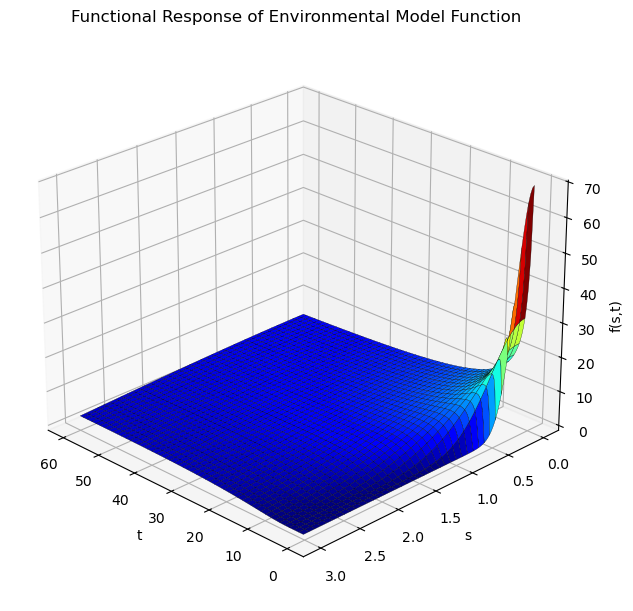

In [4]:
# Verify the correctness of function by plotting the output
# Parameters from the SFU page: M=10, D=0.07
x = np.array([10.0, 0.07])

# Create a denser spatial grid (0..3) to visualize a smooth surface; time grid as in page
s_grid = np.linspace(0.0, 3.0, 121)          
t_grid = np.arange(0.3, 60.0 + 1e-12, 0.3)  

Y = environ(x, s=s_grid, t=t_grid, return_grid=True)  # (ds, dt)

# Mesh for plotting
T, S = np.meshgrid(t_grid, s_grid, indexing='xy')

# Plot
fig = plt.figure(figsize=(8,6), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T, S, Y, cmap='jet', edgecolor='k', linewidth=0.2, antialiased=True, shade=True)

ax.set_title("Functional Response of Environmental Model Function")
ax.set_xlabel("t")
ax.set_ylabel("s")
ax.set_zlabel("")  # suppress default
ax.tick_params(axis='z', pad=2)
ax.text2D(1.05, 0.5, "f(s,t)", 
          transform=ax.transAxes,
          rotation=90, 
          va="center", ha="left",
          clip_on=False)
ax.view_init(elev=25, azim=135)
plt.savefig(IMG_DIR / "environ_surface_jet.png", dpi=300)
plt.show()

### Define input domain

In [5]:
M_MIN_MAX = [7, 13]
D_MIN_MAX = [0.02, 0.12]
INPUT_DOMAIN = np.array([M_MIN_MAX, D_MIN_MAX])

### Latin Hypercube Sampling to obtain input design points and output response

In [6]:
# Define LHS sampler
sampler = LHS(ndim=2, bounds=INPUT_DOMAIN)

# Generate samples to obtain input X
nsamples = 250
X = sampler.sample(nsamples)
print(f"Input X shape: {X.shape}")

# Evaluate function to obtain output Y
s_grid = np.linspace(0.0, 3.0, 50) 
t_grid = np.arange(0.3, 20 + 1e-12, 0.1)  
Y = environ(X, s=s_grid, t=t_grid)
print(f"Output Y shape: {Y.shape}")     

Input X shape: (250, 2)
Output Y shape: (250, 9900)


### Train/Test Split

In [7]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Train X shape: {train_X.shape}, Test X shape: {test_X.shape}")
print(f"Train Y shape: {train_Y.shape}, Test Y shape: {test_Y.shape}")

Train X shape: (200, 2), Test X shape: (50, 2)
Train Y shape: (200, 9900), Test Y shape: (50, 9900)


### Train GP
#### (1) PPGaSP in RobustGaSP

In [8]:
# Model setup
emulator = PPGaSP(ndim=train_X.shape[1])
    
# Training
start_time = time.time()
emulator.train(design=train_X, response=train_Y)
training_time = time.time() - start_time

# Prediction
start_time = time.time()
predictions = emulator.predict(test_X)
infer_time = time.time() - start_time

predictions_mean = predictions[:, :, 0]
predictions_lower = predictions[:, :, 1]
predictions_upper = predictions[:, :, 2]
predictions_std = predictions[:, :, 3]

# Evaluation metrics
RMSE_ppgasp = ErrorMetrics.RMSE(predictions=predictions_mean, observations=test_Y)
coverage_prob_ppgasp = ErrorMetrics.CoverageProbability(predictions_mean, 
                                                        predictions_lower, 
                                                        predictions_upper,
                                                        test_Y)
ppgasp_results = {
    "prediction_mean": predictions_mean,
    "prediction_std": predictions_std,
    "rmse": RMSE_ppgasp,
    "coverage_prob": coverage_prob_ppgasp,
    "training_time": training_time,
    "infer_time": infer_time
}
print(f"Training PPGaSP takes {(training_time):.3f} s")
print(f"Inference PPGaSP time takes {(infer_time):.3f} s")
print(f'PPGaSP RMSE: {RMSE_ppgasp: .5f}')
print(f'PPGaSP Coverage probability: {coverage_prob_ppgasp: .5f}')

The upper bounds of the range parameters are 46.90907 0.7814766 
The initial values of range parameters are 0.9381814 0.01562953 
Start of the optimization  1  : 
The number of iterations is  27 
 The value of the  marginal posterior  function is  11973404 
 Optimized range parameters are 46.90907 0.1652894 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
The initial values of range parameters are 0.1196946 0.001994039 
Start of the optimization  2  : 
The number of iterations is  39 
 The value of the  marginal posterior  function is  11973401 
 Optimized range parameters are 46.90907 0.1650408 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
Training PPGaSP takes 26.070 s
Inference PPGaSP time takes 0.042 s
PPGaSP RMSE:  0.00007
PPGaSP Coverage probability:  0.99212


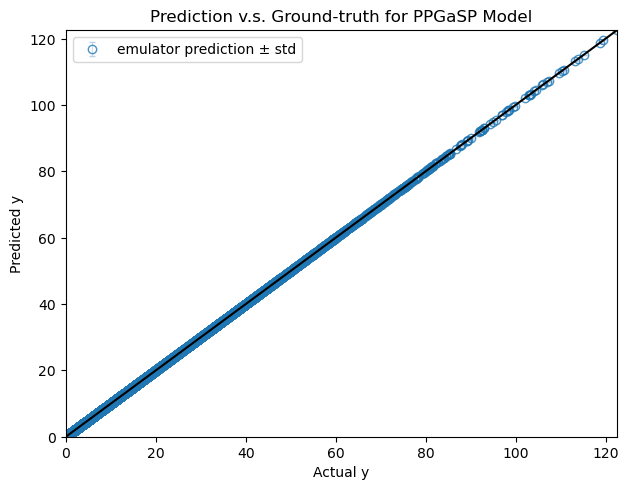

In [9]:
preds = np.dstack((predictions_mean, predictions_std))
viz_prediction(test_Y, preds, model_name="PPGaSP")

#### (2) BiGP (PPGaSP in GPytorch)

In [10]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
emulator = MoGP_GPytorch(device=device, kernel_type='matern_5_2', mimic_ppgasp=True)

# Training
training_time = emulator.train(train_X=train_X, train_Y=train_Y, num_epochs=50, lr=0.1)

# Prediction
mean, std, lower, upper, infer_time = emulator.predict(test_X=test_X)

RMSE_gpytorch = ErrorMetrics.RMSE(predictions=mean, observations=test_Y)    
coverage_prob_gpytorch = ErrorMetrics.CoverageProbability(mean, lower, upper, test_Y)

bigp_results = {
    "prediction_mean": mean,
    "prediction_std": std,
    "rmse": RMSE_gpytorch,
    "coverage_prob": coverage_prob_gpytorch,
    "training_time": training_time,
    "infer_time": infer_time
}

print(f"Training BiGP takes {(training_time):.3f} s")
print(f"Inference BiGP time takes {(infer_time):.3f} s")
print(f'GPytorch RMSE: {RMSE_gpytorch: .5f}')
print(f'GPytorch Coverage probability: {coverage_prob_gpytorch: .5f}')

training...:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0/50, Loss: 3.151


training...:  20%|██        | 10/50 [01:43<06:32,  9.81s/it]

Epoch 10/50, Loss: 2.201


training...:  40%|████      | 20/50 [03:19<04:40,  9.34s/it]

Epoch 20/50, Loss: 1.936


training...:  60%|██████    | 30/50 [04:54<03:13,  9.68s/it]

Epoch 30/50, Loss: 1.751


training...:  80%|████████  | 40/50 [06:34<01:39,  9.92s/it]

Epoch 40/50, Loss: 1.443


training...: 100%|██████████| 50/50 [08:30<00:00, 10.21s/it]


Training GPytorch takes 510.344 s
Training BiGP takes 510.344 s
Inference BiGP time takes 20.343 s
GPytorch RMSE:  1.21424
GPytorch Coverage probability:  0.99408


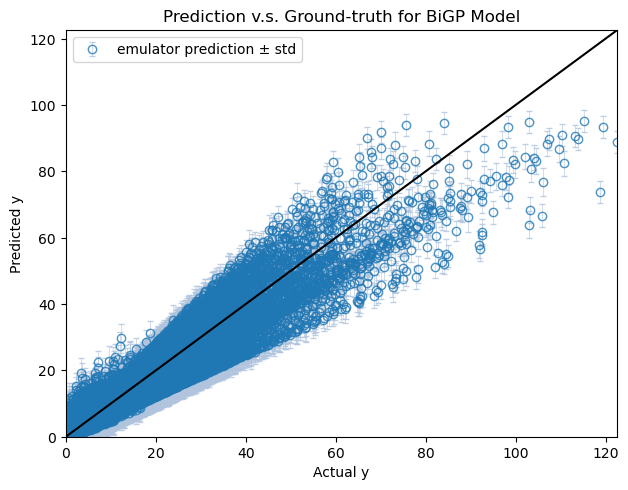

In [11]:
preds = np.dstack((mean, std))
viz_prediction(test_Y, preds, model_name="BiGP")

#### (3) MTGP (LMC)

In [12]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
emulator = MultiTask_GP(base_inducing=64, min_rank=10, use_pca_init=True, device=device)

# Training
training_time = emulator.train(train_X=train_X, train_Y=train_Y, epochs=500, lr=0.1, enable_scheduler=True)

# Prediction
mean, std, lower, upper, infer_time = emulator.predict(test_X=test_X)
RMSE_svgp_lmc = ErrorMetrics.RMSE(predictions=mean, observations=test_Y)
coverage_prob_svgp_lmc = ErrorMetrics.CoverageProbability(mean, 
                                                            lower, 
                                                            upper,
                                                            test_Y)
print(f"Training MTGP takes {(training_time):.3f} s")
print(f"Inference MTGP time takes {(infer_time):.3f} s")
print(f'MTGP RMSE: {RMSE_svgp_lmc: .5f}')
print(f'MTGP Coverage probability: {coverage_prob_svgp_lmc: .5f}')

INFO:gpytorch_emulator.svgp_lmc:Normalizing data...
INFO:gpytorch_emulator.svgp_lmc:Problem size: 2 inputs → 9900 outputs
INFO:gpytorch_emulator.svgp_lmc:Training samples: 200
INFO:gpytorch_emulator.svgp_lmc:Base parameters: base_inducing=64, min_rank=10
INFO:gpytorch_emulator.svgp_lmc:Calculated parameters: rank=10, num_inducing=80
INFO:gpytorch_emulator.svgp_lmc:Explained variance at rank 10: 1.000
INFO:gpytorch_emulator.svgp_lmc:Initializing inducing points with k-means clustering...
INFO:gpytorch_emulator.svgp_lmc:Initialized inducing points with shape: torch.Size([10, 80, 2])
INFO:gpytorch_emulator.svgp_lmc:Initializing LMC mixing matrix with PCA...
INFO:gpytorch_emulator.svgp_lmc:PCA explained variance ratio: [6.1788350e-01 3.1028470e-01 6.2172584e-02 8.5003274e-03 1.0263056e-03
 1.1907048e-04 1.2420480e-05 1.1037403e-06 1.0569761e-07 8.3630178e-09]...
INFO:gpytorch_emulator.svgp_lmc:Total explained variance: 1.0000
INFO:gpytorch_emulator.svgp_lmc:LMC coefficients initialized wit

Epoch   0, Loss: 76227.320, Beta: 0.0010, LR: 0.005000


training...:   6%|▌         | 29/500 [00:01<00:28, 16.74it/s]

Epoch  25, Loss: 3449.905, Beta: 0.0010, LR: 0.099961


training...:  11%|█         | 53/500 [00:03<00:27, 16.19it/s]

Epoch  50, Loss: -2211.218, Beta: 0.0077, LR: 0.098974


training...:  16%|█▌        | 79/500 [00:04<00:25, 16.40it/s]

Epoch  75, Loss: -10769.570, Beta: 0.0240, LR: 0.096679


training...:  21%|██        | 103/500 [00:06<00:24, 16.41it/s]

Epoch 100, Loss: 9952.628, Beta: 0.0768, LR: 0.093137
  Avg lengthscale: 3.110, Avg outputscale: 0.282


training...:  26%|██▌       | 129/500 [00:08<00:24, 15.33it/s]

Epoch 125, Loss: -15307.191, Beta: 0.2235, LR: 0.088442


training...:  31%|███       | 153/500 [00:09<00:22, 15.69it/s]

Epoch 150, Loss: -18191.568, Beta: 0.5005, LR: 0.082721


training...:  36%|███▌      | 179/500 [00:11<00:22, 14.38it/s]

Epoch 175, Loss: -19553.822, Beta: 0.7775, LR: 0.076125


training...:  41%|████      | 203/500 [00:13<00:19, 15.30it/s]

Epoch 200, Loss: -20245.553, Beta: 0.9242, LR: 0.068831
  Avg lengthscale: 3.084, Avg outputscale: 0.293


training...:  46%|████▌     | 229/500 [00:15<00:18, 14.97it/s]

Epoch 225, Loss: -20616.646, Beta: 0.9770, LR: 0.061035


training...:  51%|█████     | 253/500 [00:16<00:17, 14.20it/s]

Epoch 250, Loss: -21520.035, Beta: 1.0000, LR: 0.052944


training...:  56%|█████▌    | 279/500 [00:18<00:14, 15.10it/s]

Epoch 275, Loss: -22706.080, Beta: 1.0000, LR: 0.044774


training...:  61%|██████    | 303/500 [00:20<00:13, 15.11it/s]

Epoch 300, Loss: -20760.029, Beta: 1.0000, LR: 0.036743
  Avg lengthscale: 3.088, Avg outputscale: 0.299


training...:  66%|██████▌   | 329/500 [00:22<00:11, 15.35it/s]

Epoch 325, Loss: -22689.912, Beta: 1.0000, LR: 0.029067


training...:  71%|███████   | 353/500 [00:23<00:09, 15.54it/s]

Epoch 350, Loss: -23350.238, Beta: 1.0000, LR: 0.021950


training...:  76%|███████▌  | 379/500 [00:25<00:07, 15.36it/s]

Epoch 375, Loss: -23604.623, Beta: 1.0000, LR: 0.015582


training...:  81%|████████  | 403/500 [00:27<00:06, 15.56it/s]

Epoch 400, Loss: -23995.902, Beta: 1.0000, LR: 0.010134
  Avg lengthscale: 3.081, Avg outputscale: 0.308


training...:  86%|████████▌ | 429/500 [00:28<00:04, 15.91it/s]

Epoch 425, Loss: -24183.350, Beta: 1.0000, LR: 0.005751


training...:  91%|█████████ | 453/500 [00:30<00:03, 15.57it/s]

Epoch 450, Loss: -24327.643, Beta: 1.0000, LR: 0.002549


training...:  96%|█████████▌| 479/500 [00:32<00:01, 15.72it/s]

Epoch 475, Loss: -24398.367, Beta: 1.0000, LR: 0.000616


training...: 100%|██████████| 500/500 [00:33<00:00, 14.89it/s]
INFO:gpytorch_emulator.svgp_lmc:Training time: 33.574 seconds
INFO:gpytorch_emulator.svgp_lmc:Starting evaluation with uncertainty quantification...
INFO:gpytorch_emulator.svgp_lmc:Inference time: 0.004 seconds


Training MTGP takes 33.574 s
Inference MTGP time takes 0.004 s
MTGP RMSE:  0.01963
MTGP Coverage probability:  0.99468


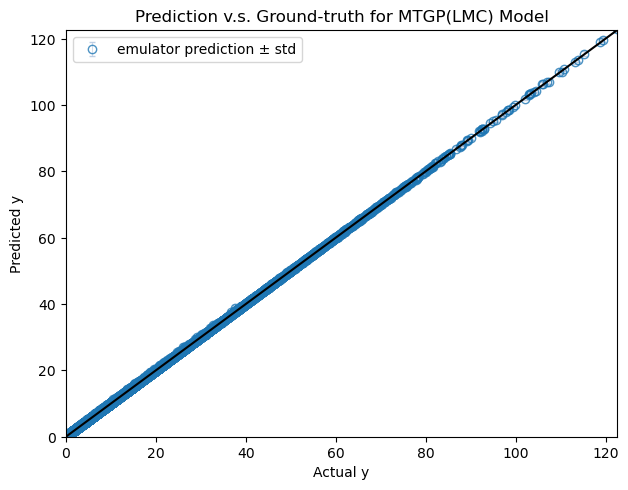

In [13]:
preds = np.dstack((mean, std))
viz_prediction(test_Y, preds, model_name="MTGP(LMC)")

### Comparative Study: Different dimensionality reduction approaches

#### PCA-PPGaSP

In [14]:
# Model setup
input_reducer  = None
output_reducer = OutputDimReducer(LinearPCA())
emulator = PCAPPGaSP(
        ndim=int(reduced_dim(input_reducer, train_X)),
        input_dim_reducer=input_reducer,
        output_dim_reducer=output_reducer,
    )
# Training
training_time = emulator.train(train_X, train_Y)

# Prediction
test_Y_scaled = emulator.output_scaler.transform(test_Y)
test_Y_scaled_reduced = emulator.output_dim_reducer.transform(test_Y_scaled)
predictions_latent, predictions_mean_original, infer_time, predictions_uncertainty = emulator.predict(test_X, uncertainty_reconstruction=True)

Number of componenets with more than 0.95 of varience : 3.
The upper bounds of the range parameters are 27.76554 27.17132 
The initial values of range parameters are 0.5553108 0.5434265 
Start of the optimization  1  : 
The number of iterations is  31 
 The value of the  marginal posterior  function is  789.9851 
 Optimized range parameters are 27.76554 5.371198 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
The initial values of range parameters are 0.07085955 0.06934307 
Start of the optimization  2  : 
The number of iterations is  28 
 The value of the  marginal posterior  function is  789.9852 
 Optimized range parameters are 27.76554 5.375742 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
Training PCAPPGaSP takes 0.724 s
Inference PCAPPGaSP takes 0.002 s


In [15]:
rmse = ErrorMetrics.RMSE(predictions=predictions_mean_original, observations=test_Y)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean_original, 
                                                        predictions_uncertainty[:, :, 0], 
                                                        predictions_uncertainty[:, :, 1],
                                                        test_Y)

# Evaluation metrics
pcappgasp_results = {
    "prediction_mean": predictions_mean_original,
    "prediction_std": predictions_uncertainty[:, :, 2],
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "training_time": training_time,
    "infer_time": infer_time
}
print(f"Training PCAPPGaSP takes {(training_time):.3f} s")
print(f"Inference PCAPPGaSP time takes {(infer_time):.3f} s")
print(f'PCAPPGaSP RMSE in original space: {rmse: .3f}')
print(f'PCAPPGaSP Coverage probability in original space: {coverage_prob: .3f}')

Training PCAPPGaSP takes 0.724 s
Inference PCAPPGaSP time takes 0.002 s
PCAPPGaSP RMSE in original space:  0.125
PCAPPGaSP Coverage probability in original space:  0.001


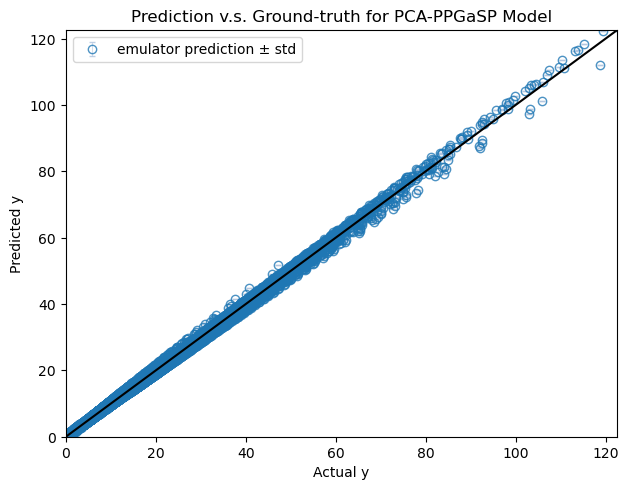

In [16]:
preds = np.dstack((pcappgasp_results["prediction_mean"] , pcappgasp_results["prediction_std"]))
viz_prediction(test_Y, preds, model_name="PCA-PPGaSP")

#### kPCA-PPGaSP

In [17]:
# Model setup
input_reducer  = None
output_reducer = OutputDimReducer(NonlinearPCA(n_components=3, alpha=1e-10))
emulator = PCAPPGaSP(
        ndim=int(reduced_dim(input_reducer, train_X)),
        input_dim_reducer=input_reducer,
        output_dim_reducer=output_reducer,
    )
# Training
training_time = emulator.train(train_X, train_Y)

# Prediction
predictions_latent, predictions_mean_original, infer_time, predictions_uncertainty = emulator.predict(test_X, uncertainty_reconstruction=True)

The upper bounds of the range parameters are 27.76554 27.17132 
The initial values of range parameters are 0.5553108 0.5434265 
Start of the optimization  1  : 
The number of iterations is  19 
 The value of the  marginal posterior  function is  2114.34 
 Optimized range parameters are 4.722016 1.464339 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
The initial values of range parameters are 0.07085955 0.06934307 
Start of the optimization  2  : 
The number of iterations is  35 
 The value of the  marginal posterior  function is  2114.34 
 Optimized range parameters are 4.721969 1.464324 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
Training PCAPPGaSP takes 0.505 s
Inference PCAPPGaSP takes 0.001 s


In [18]:
# Evaluation metrics
rmse = ErrorMetrics.RMSE(predictions=predictions_mean_original, observations=test_Y)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean_original, 
                                                 predictions_uncertainty[:, :, 0], 
                                                 predictions_uncertainty[:, :, 1],
                                                 test_Y)
pcappgasp_results = {
    "prediction_mean": predictions_mean_original,
    "prediction_std": predictions_uncertainty[:, :, 2],
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "training_time": training_time,
    "infer_time": infer_time
}
print(f"Training kPCAPPGaSP takes {(training_time):.3f} s")
print(f"Inference kPCAPPGaSP time takes {(infer_time):.3f} s")
print(f'kPCAPPGaSP RMSE in original space: {rmse: .3f}')
print(f'kPCAPPGaSP Coverage probability in original space: {coverage_prob: .3f}')

Training kPCAPPGaSP takes 0.505 s
Inference kPCAPPGaSP time takes 0.001 s
kPCAPPGaSP RMSE in original space:  0.348
kPCAPPGaSP Coverage probability in original space:  0.006


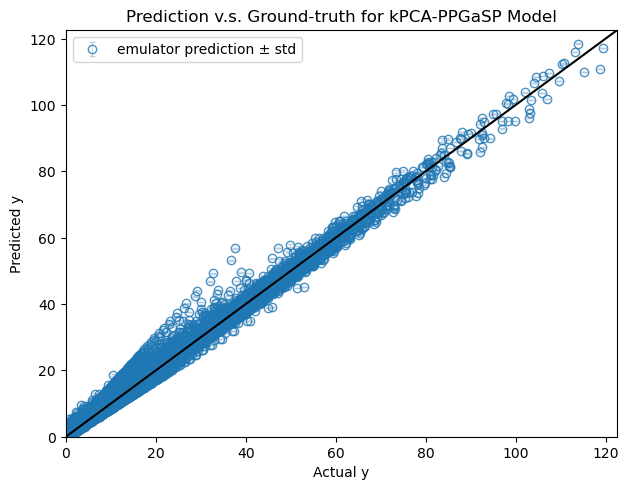

In [19]:
preds = np.dstack((pcappgasp_results["prediction_mean"] , pcappgasp_results["prediction_std"]))
viz_prediction(test_Y, preds, model_name="kPCA-PPGaSP")

#### AE-PPGaSP

In [20]:
# AE architecture
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=None):
        super().__init__()
        
        # Default hidden dimensions if none provided
        if hidden_dims is None:
            hidden_dims = [32, 16, 8]
            
        # Build encoder layers
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Build decoder layers (reverse of encoder)
        decoder_layers = []
        prev_dim = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
train_Y_tensor = torch.FloatTensor(train_Y)
test_Y_tensor = torch.FloatTensor(test_Y)
input_dim = train_Y_tensor.shape[1]  # Number of input features
latent_dim = 8  # Desired number of output dimensions
model = AutoEncoder(input_dim=input_dim, latent_dim=latent_dim, hidden_dims=[1024, 256, 256, 16])

# Loss function and optimizer
loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)

# Training the autoencoder
losses = []
num_epochs = 1000
model.train()
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_Y_tensor)
    loss = loss_function(outputs, train_Y_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Loss for each epoch
    losses.append(loss.item())
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/1000], Loss: 73.9627
Epoch [2/1000], Loss: 406.7000
Epoch [3/1000], Loss: 73.1353
Epoch [4/1000], Loss: 73.2308
Epoch [5/1000], Loss: 71.7816
Epoch [6/1000], Loss: 65.1885
Epoch [7/1000], Loss: 45.3147
Epoch [8/1000], Loss: 45.6863
Epoch [9/1000], Loss: 24.2299
Epoch [10/1000], Loss: 27.4332
Epoch [11/1000], Loss: 22.7067
Epoch [12/1000], Loss: 11.6729
Epoch [13/1000], Loss: 21.6612
Epoch [14/1000], Loss: 11.3940
Epoch [15/1000], Loss: 11.0757
Epoch [16/1000], Loss: 13.0054
Epoch [17/1000], Loss: 8.9649
Epoch [18/1000], Loss: 5.8835
Epoch [19/1000], Loss: 10.3131
Epoch [20/1000], Loss: 4.7255
Epoch [21/1000], Loss: 6.6950
Epoch [22/1000], Loss: 7.2324
Epoch [23/1000], Loss: 4.5886
Epoch [24/1000], Loss: 4.5704
Epoch [25/1000], Loss: 5.9526
Epoch [26/1000], Loss: 3.3957
Epoch [27/1000], Loss: 4.0278
Epoch [28/1000], Loss: 4.5781
Epoch [29/1000], Loss: 3.2662
Epoch [30/1000], Loss: 2.9148
Epoch [31/1000], Loss: 3.8957
Epoch [32/1000], Loss: 2.7600
Epoch [33/1000], Loss: 2.7775
E

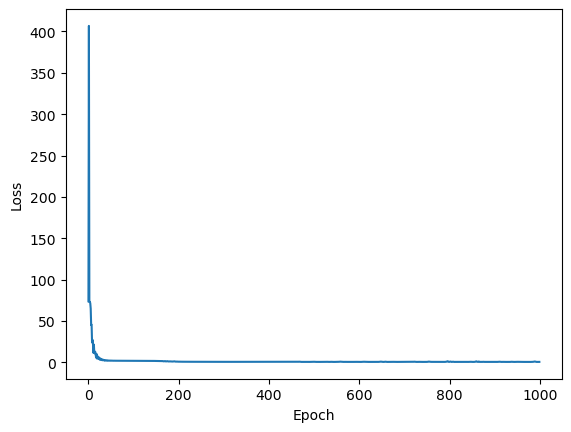

In [22]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [23]:
model.eval()
with torch.no_grad():
    train_Y_reduced = model.encoder(train_Y_tensor).detach().numpy()
    test_Y_reduced = model.encoder(test_Y_tensor).detach().numpy()
    
# Model setup
emulator = PPGaSP(ndim=train_X.shape[1])

# Training
start_time = time.time()
emulator.train(design=train_X, response=train_Y_reduced)
training_time = time.time() - start_time

# Prediction
start_time = time.time()
predictions = emulator.predict(test_X)
infer_time = time.time() - start_time

predictions_mean_original = model.decoder(torch.FloatTensor(predictions[:, :, 0])).detach().numpy()


The upper bounds of the range parameters are 46.90907 0.7814766 
The initial values of range parameters are 0.9381814 0.01562953 
Start of the optimization  1  : 
The number of iterations is  20 
 The value of the  marginal posterior  function is  9546.797 
 Optimized range parameters are 46.90907 0.2597391 
 Optimized nugget parameter is 0 
 Convergence:  FALSE 
The initial values of range parameters are 0.1196946 0.001994039 
Start of the optimization  2  : 
The number of iterations is  20 
 The value of the  marginal posterior  function is  9546.916 
 Optimized range parameters are 46.90907 0.2595829 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 


In [24]:
num_mc_samples = 100
original_dim = train_Y.shape[1]
mean_reduced = predictions[:, :, 0]
std_reduced = predictions[:, :, 3]
num_test, reduced_dim = mean_reduced.shape
# Generate samples in reduced space
rng = np.random.default_rng()
latent_samples = rng.normal(loc=mean_reduced[:, :, None], scale=std_reduced[:, :, None], size=(num_test, reduced_dim, num_mc_samples))
# Reconstruct original output space
original_samples = np.zeros((num_test, original_dim, num_mc_samples))
latent_flat = latent_samples.transpose(0, 2, 1).reshape(num_test * num_mc_samples, reduced_dim)
original_flat = model.decoder(torch.FloatTensor(latent_flat)).detach().numpy()
original_samples = original_flat.reshape(num_test, num_mc_samples, original_dim).transpose(0, 2, 1)
# Compute statistics across samples
std_original = np.std(original_samples, axis=2)
margin = 1.96 * std_original
lower_CI = predictions_mean_original - margin
upper_CI = predictions_mean_original + margin 

In [25]:
# Evaluation metrics
rmse = ErrorMetrics.RMSE(predictions=predictions_mean_original, observations=test_Y)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean_original, 
                                                 lower_CI, 
                                                 upper_CI,
                                                 test_Y)
ae_ppgasp_results = {
    "prediction_mean": predictions_mean_original,
    "prediction_std": std_original,
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "training_time": training_time,
    "infer_time": infer_time
}
print(f"Training AE-PPGaSP takes {(training_time):.3f} s")
print(f"Inference AE-PPGaSP time takes {(infer_time):.3f} s")
print(f'AE-PPGaSP RMSE in original space: {rmse: .3f}')
print(f'AE-PPGaSP Coverage probability in original space: {coverage_prob: .3f}')

Training AE-PPGaSP takes 0.461 s
Inference AE-PPGaSP time takes 0.002 s
AE-PPGaSP RMSE in original space:  0.862
AE-PPGaSP Coverage probability in original space:  0.000


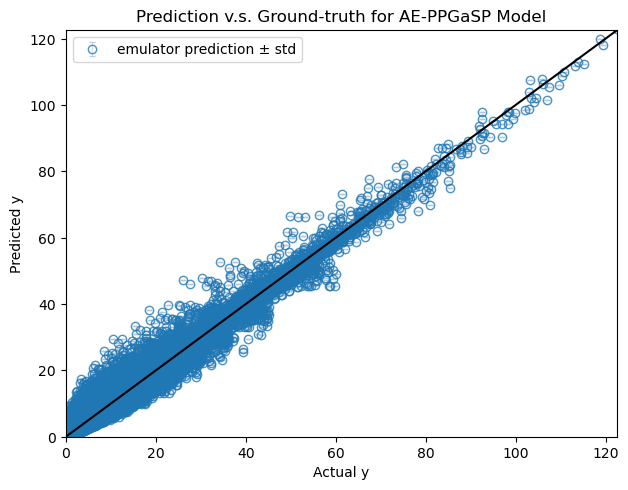

In [26]:
preds = np.dstack((predictions_mean_original, std_original))
viz_prediction(test_Y, preds, model_name="AE-PPGaSP")

#### VAE-PPGaSP

In [27]:
# VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=None, device='cpu'):
        super(VAE, self).__init__()
        self.device = device
        
        # Default hidden dimensions if none provided
        if hidden_dims is None:
            hidden_dims = [4096, 2048, 1024, 512, 256]
            
        # Build encoder layers
        encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.GELU()
            ])
            prev_dim = hidden_dim
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Latent mean and variance layers
        self.mean_layer = nn.Linear(hidden_dims[-1], latent_dim)
        self.logvar_layer = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Initialize mean and logvar layers carefully
        nn.init.zeros_(self.mean_layer.bias)
        nn.init.zeros_(self.logvar_layer.bias)
        nn.init.xavier_uniform_(self.mean_layer.weight, gain=0.01)
        nn.init.xavier_uniform_(self.logvar_layer.weight, gain=0.01)
        
        # Build decoder layers (reverse of encoder)
        decoder_layers = []
        prev_dim = latent_dim
        for hidden_dim in reversed(hidden_dims):
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.GELU()
            ])
            prev_dim = hidden_dim
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
     
    def encode(self, x):
        # encoder
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        # reparameterization
        epsilon = torch.randn_like(logvar).to(self.device)      
        z = mean + torch.exp(0.5 * logvar) * epsilon  
        return z, mean, logvar

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        z, mean, logvar = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, mean, logvar 

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
train_Y_tensor = torch.FloatTensor(train_Y)
test_Y_tensor = torch.FloatTensor(test_Y)

# Normalize your data
y_mean = train_Y_tensor.mean(0, keepdim=True)
y_std = train_Y_tensor.std(0, keepdim=True)
train_Y_normalized = (train_Y_tensor - y_mean) / (y_std + 1e-8)
test_Y_normalized = (test_Y_tensor - y_mean) / (y_std + 1e-8)

# Create DataLoader
batch_size = 16
train_dataset = TensorDataset(train_Y_normalized)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Setting random seed for reproducibility
input_dim = train_Y_tensor.shape[1]  # Number of input features
latent_dim = 8  # Desired number of output dimensions
model = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dims=[2048, 1024, 256, 64] , device=device).to(device)

# Loss function and optimizer
def loss_function(x, x_hat, mean, log_var, epoch=None, total_epochs=None,
                  beta=1.0, capacity_max=25.0, capacity_warmup=0.3, free_bits=None):
    recon_loss = nn.functional.mse_loss(x_hat, x, reduction='none') # [B, D]
    recon_loss = recon_loss.sum(dim=1).mean()
    kl_per_dim = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()) # [B, Z]
    if free_bits is not None:
        # prevent over-penalization
        kl_per_dim = torch.clamp(kl_per_dim, min=free_bits)
    kl_loss = kl_per_dim.sum(dim=1).mean() 
    
    # Capacity schedule: linearly increase target information C
    if epoch is not None and total_epochs is not None:
        warmup_T = int(capacity_warmup * total_epochs)
        if epoch < warmup_T:
            C = capacity_max * (epoch / max(1, warmup_T))
        else:
            C = capacity_max
    else:
        C = capacity_max


    # β-weighted deviation from capacity
    loss = recon_loss + beta * torch.abs(kl_loss - C)
    
    return loss, recon_loss, kl_loss, C
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-04, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=100, min_lr=1e-5
    )

# Training
losses = []
recon_losses = []
kl_losses = []
num_epochs = 1000
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0
    for batch_idx, (data,) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        outputs, mean, logvar = model(data)
        loss, recon_loss, kl_loss, C = loss_function(
            outputs, data, mean, logvar, 
            epoch=epoch, total_epochs=num_epochs,
            beta=0.1,              
            capacity_max=25.0,     
            capacity_warmup=0.3,   # 30% warmup
            free_bits=0.02         
        )
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_recon += recon_loss.item()
        epoch_kl += kl_loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    avg_recon = epoch_recon / len(train_loader)
    avg_kl = epoch_kl / len(train_loader)
    
    scheduler.step(avg_loss)
    
    losses.append(avg_loss)
    recon_losses.append(avg_recon)
    kl_losses.append(avg_kl)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.2f}, C: {C:.2f}")

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
# Encoding the data using the trained variational autoencoder
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    # Encode normalized data
    train_Y_reduced = model.encode(train_Y_tensor.to(device))[0].cpu().detach().numpy()
    test_Y_reduced = model.encode(test_Y_tensor.to(device))[0].cpu().detach().numpy()
   
# Model setup
emulator = PPGaSP(ndim=train_X.shape[1])

# Training
start_time = time.time()
emulator.train(design=train_X, response=train_Y_reduced)
training_time = time.time() - start_time

# Prediction
start_time = time.time()
predictions = emulator.predict(test_X)
infer_time = time.time() - start_time

# Decode predictions
predictions_mean_normalized = model.decode(torch.FloatTensor(predictions[:, :, 0]).to(device)).cpu().detach().numpy()
# Denormalize predictions
predictions_mean_original = predictions_mean_normalized * (y_std.detach().numpy() + 1e-8) + y_mean.detach().numpy()

In [ ]:
num_mc_samples = 100
original_dim = train_Y.shape[1]
mean_reduced = predictions[:, :, 0]
std_reduced = predictions[:, :, 3]
num_test, reduced_dim = mean_reduced.shape
# Generate samples in reduced space
rng = np.random.default_rng()
latent_samples = rng.normal(loc=mean_reduced[:, :, None], scale=std_reduced[:, :, None], size=(num_test, reduced_dim, num_mc_samples))
# Reconstruct original output space
original_samples = np.zeros((num_test, original_dim, num_mc_samples))
latent_flat = latent_samples.transpose(0, 2, 1).reshape(num_test * num_mc_samples, reduced_dim)
original_flat = model.decode(torch.FloatTensor(latent_flat).to(device)).cpu().detach().numpy()
original_flat = original_flat * (y_std.detach().numpy() + 1e-8) + y_mean.detach().numpy()
original_samples = original_flat.reshape(num_test, num_mc_samples, original_dim).transpose(0, 2, 1)
# Compute statistics across samples
std_original = np.std(original_samples, axis=2)
margin = 1.96 * std_original
lower_CI = predictions_mean_original - margin
upper_CI = predictions_mean_original + margin 

In [ ]:
# Evaluation metrics
rmse = ErrorMetrics.RMSE(predictions=predictions_mean_original, observations=test_Y)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean_original, 
                                                 lower_CI, 
                                                 upper_CI,
                                                 test_Y)
vae_ppgasp_results = {
    "prediction_mean": predictions_mean_original,
    "prediction_std": std_original,
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "training_time": training_time,
    "infer_time": infer_time
}
print(f"Training VAE-PPGaSP takes {(training_time):.3f} s")
print(f"Inference VAE-PPGaSP time takes {(infer_time):.3f} s")
print(f'VAE-PPGaSP RMSE in original space: {rmse: .3f}')
print(f'VAE-PPGaSP Coverage probability in original space: {coverage_prob: .3f}')

In [ ]:
preds = np.dstack((predictions_mean_original, std_original))
viz_prediction(test_Y, preds, model_name="VAE-PPGaSP")